In [45]:
import numpy as _np
import matplotlib.pyplot as _plt
import pandas as _pd
import sympy as _sp
import glob as _gl
import pymad8 as _m8
import pybdsim as _bd
import beamTracking

import os
import subprocess

from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from functools import partial

In [2]:
date = "2023_04_18"
save_name_prefix = "plots/BeamWire/" + date + "_T20_plot"

In [4]:
def SetWire(diameter=0.1, length=0.03, material="tungsten", offsetX=0, checkWire=True):
    defaultWire = """WIRE: wirescanner, aper1=0.1, apertureType="circular", l=0.1, wireDiameter=0.1*mm, wireLength=0.03, material="tungsten", wireOffsetX=0.0*mm;"""
    newWire = """WIRE: wirescanner, aper1=0.1, apertureType="circular", l=0.1, wireDiameter={}*mm, wireLength={}, material="{}", wireOffsetX={}*mm;""".format(diameter,length,material,offsetX)

    comp = _bd.Gmad.GmadFileComponents("../03_bdsimModel/T20_for_wire_components_template.gmad")
    comp.s = comp.s.replace(defaultWire,newWire)
    comp.write("../03_bdsimModel/T20_for_wire_components.gmad")
    
    if checkWire:
        header, elemlist = comp.s.split("\n\n")
        header = header.split("\n")
        elemlist = elemlist.split("\n")
        for e in elemlist:
            if "WIRE" in e:
                wire = e
        print(wire)
        
def CountPhotons():
    data = _bd.Data.Load("../04_dataLocal/T20_for_wire.root")
    e = data.GetEvent()
    et = data.GetEventTree()
    npart = et.GetEntries()
    sampler_data = e.GetSampler("DRIFT.")

    C=0
    for evt in et:
        C+=list(sampler_data.partID).count(22)
    return(C)

def SetRunCount(diameter=0.1, offsetX=0):
    SetWire(diameter=diameter, offsetX=offsetX, checkWire=False)
    _bd.Run.Bdsim("../03_bdsimModel/T20_for_wire.gmad", "../04_dataLocal/T20_for_wire", ngenerate=5000, silent=True)
    return CountPhotons()

In [6]:
OFFSET = _np.linspace(-0.35, 0.35, 21)

def MeasureNPhotons(diameter):
    NPHOTONS = []
    for offset in OFFSET:
        NPHOTONS.append(SetRunCount(diameter, offset))
        print(offset)
    print('DONE')
    return NPHOTONS

NPHOTONS1 = MeasureNPhotons(0.1)
NPHOTONS2 = MeasureNPhotons(0.5)
NPHOTONS3 = MeasureNPhotons(1)

BDSIM output file - using DataLoader
-0.35
BDSIM output file - using DataLoader
-0.315
BDSIM output file - using DataLoader
-0.27999999999999997
BDSIM output file - using DataLoader
-0.245
BDSIM output file - using DataLoader
-0.21
BDSIM output file - using DataLoader
-0.175
BDSIM output file - using DataLoader
-0.14
BDSIM output file - using DataLoader
-0.10500000000000001
BDSIM output file - using DataLoader
-0.07
BDSIM output file - using DataLoader
-0.03500000000000003
BDSIM output file - using DataLoader
0.0
BDSIM output file - using DataLoader
0.034999999999999976
BDSIM output file - using DataLoader
0.06999999999999995
BDSIM output file - using DataLoader
0.10499999999999998
BDSIM output file - using DataLoader
0.13999999999999996
BDSIM output file - using DataLoader
0.17499999999999993
BDSIM output file - using DataLoader
0.20999999999999996
BDSIM output file - using DataLoader
0.245
BDSIM output file - using DataLoader
0.2799999999999999
BDSIM output file - using DataLoader
0.

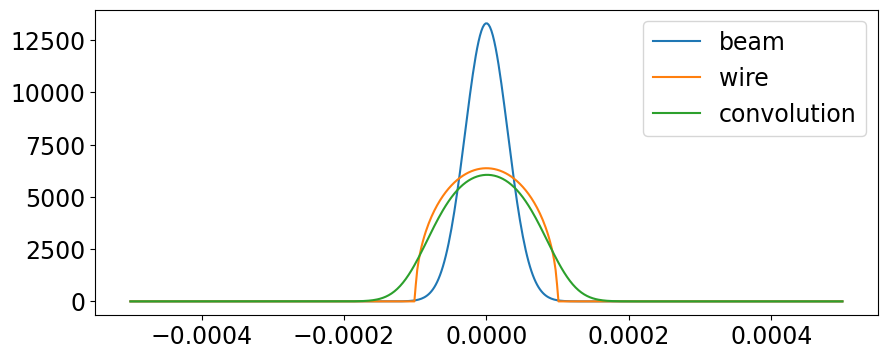

In [226]:
def gaus(x, a, sigma, mu) :
    return a/(_np.sqrt(2*_np.pi)*sigma)*_np.exp(-(x-mu)**2/(2*sigma**2))
    
def semicircle(x, b, R) :
    circ = b/(_np.pi*R**2/2)*_np.sqrt(R**2-x**2)
    _np.nan_to_num(circ, False, 0.0)
    return circ

def func_conv(x, A=1, sigma=3e-5, mu=0, R=1e-4):
    y_gaus = gaus(X, 1, sigma, mu)
    y_circ  = semicircle(X, 1, R)
    
    conv = _np.convolve(y_gaus, y_circ, "same")
    conv = conv/simps(conv, X)
    
    func = interp1d(X, conv, fill_value='extrapolate')
    return A*func(x)
    
    
_plt.rcParams['font.size'] = 17
fig, ax = _plt.subplots(1,1,figsize=(9,4))
fig.tight_layout()

X = _np.linspace(-5e-4, 5e-4, 500)
_plt.plot(X, gaus(X, a=1, sigma=3e-5, mu=0), label='beam')
_plt.plot(X, semicircle(X, b=1, R=1e-4), label='wire')
_plt.plot(X, func_conv(X), ls='-', label='convolution')
_plt.legend()

[ 2.81192882e+03  1.00575316e-01 -1.15337877e-03  2.43481655e-01]
[ 2.81131770e+03  9.48505337e-02 -1.19583946e-03]


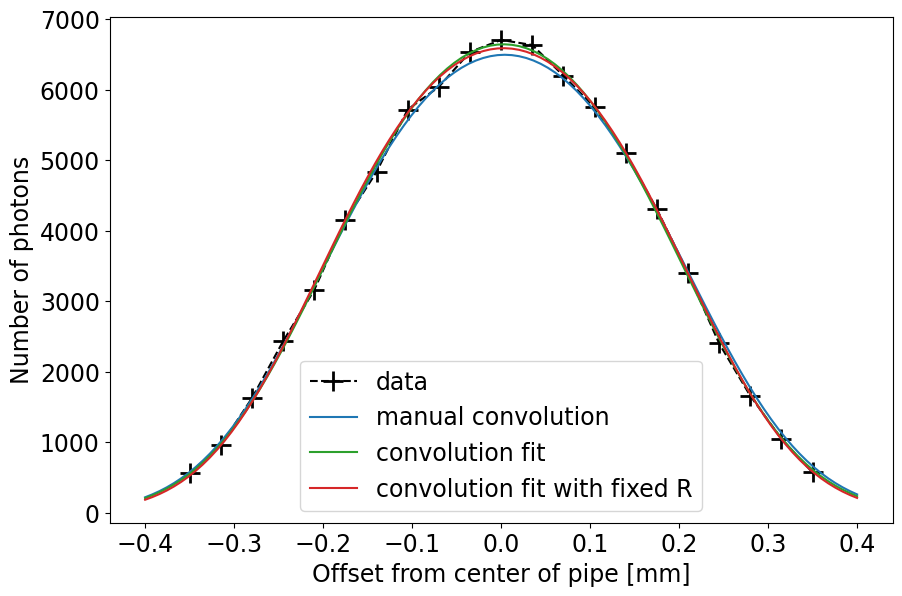

In [228]:
NPHOTONS = NPHOTONS2

_plt.rcParams['font.size'] = 17
fig, ax = _plt.subplots(1,1,figsize=(9,6))
fig.tight_layout()

_plt.plot(OFFSET, NPHOTONS, '+--', color="k", markersize=15, markeredgewidth=2, label='data')

X = _np.linspace(-0.4, 0.4, num=100)

_plt.plot(X, func_conv(X, A=2.8e3, sigma=0.1, mu=0, R=0.25), '-', color="C0", label='manual convolution')

popt, pcov = curve_fit(func_conv, OFFSET, NPHOTONS, p0=[2e3, 0.11, 0, 0.1])
print(popt)
_plt.plot(X, func_conv(X, A=popt[0], sigma=popt[1], mu=popt[2], R=popt[3]), '-', color="C2", label='convolution fit')

popt, pcov = curve_fit(lambda x, _A, _sigma, _mu: func_conv(x, _A, _sigma, _mu, R=0.25), OFFSET, NPHOTONS, p0=[2e3, 0.11, 0])
print(popt)
_plt.plot(X, func_conv(X, A=popt[0], sigma=popt[1], mu=popt[2], R=R), '-', color="C3", label='convolution fit with fixed R')

_plt.xlabel('Offset from center of pipe [mm]')
_plt.ylabel('Number of photons')
_plt.legend()

_plt.savefig("{}_TEST_profile".format(save_name_prefix), dpi="figure", bbox_inches='tight', facecolor="#FF000000")

In [229]:
x = _sp.Symbol("x", real=True)

sigma = _sp.Symbol("sigma", real=True, positive=True)
g = 1/(_sp.sqrt(2*_sp.pi)*sigma)*_sp.exp(-(x)**2/(2*sigma**2))

R = _sp.Symbol("R", real=True, positive=True)
w = 1/(_sp.pi*R**2/2)*_sp.sqrt(R**2-x**2)

print(_sp.integrate(g,(x, -_sp.oo, _sp.oo)))
print(_sp.integrate(w,(x, -R, R)))

xt = _sp.Symbol("xt", real=True)
_sp.integrate(g.subs(x,x-xt)*w.subs(x, xt), (xt, -_sp.oo, _sp.oo))

integ = _sp.sqrt(R**2-xt**2)*_sp.exp(-xt**2/(2*sigma**2))*_sp.exp(x*xt/sigma**2)
_sp.integrate(integ, (xt,  -_sp.oo, _sp.oo))

1
1


Integral(sqrt((R - xt)*(R + xt))*exp(-xt**2/(2*sigma**2))*exp(x*xt/sigma**2), (xt, -oo, oo))